## Shortest path relation extraction with word embeddings
Approach:
* Locate Named Entities in the sentece
* Extract dependency path of the sentence using the spaCy dependy parser
* Build an undirected network graph of the dependencies in the sentece
* Search for the shortest path between every two entities and assume them as related to be each other
* Computer feature vector (word embedding) for shortest path feature
* Cluster the entities depending on features

In [1]:
import enum
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import logging
import pandas as pd
import numpy as np
import re

from networkx.exception import NodeNotFound, NetworkXNoPath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize

nlp = spacy.load('de')
model = KeyedVectors.load_word2vec_format('../models/german.model', binary=True)

c:\program files\python\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
relationship_list = ['vater', 'mutter', 'sohn', 'tochter', 'bruder', 'schwester', 'enkel', 'enkelin', 'nichte',
                     'neffe', 'onkel', 'tante']
me_list = ['ich', 'meine', 'mein', 'meiner', 'meinem', 'meinen']

In [113]:
#text = u'''Herbert ist der Vater von Hans'''
#text = u'''Peter und Maria gehen morgen ins Kino'''
#text = u'''Herbert sein Sohn und ich gehen heute ins Kino'''
# text = u'''Ich gehe mit Johann in den Zoo'''
#text = u'''Hans und sein Sohn Hubert gehen in den Zoo.'''
text = u'''Hans, welcher der Sohn von Hubert ist, geht mit Peter ins Kino.'''
#text = u'''Meine kleine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London.'''
#text = u'''Ich fahre mit meinen Enkeln Lukas und Lisa in den Urlaub.'''
#text = u'''Potesters seized several pumping stations, holding 127 Shell workers hostage.'''
#text = u'''Troops recently have raided churches, warning ministers to stop preaching.'''
multiline_text = u'''Bart, welcher der Sohn von Homer ist, geht mit Milhouse ins Kino.
Meine kleine Enkelin Lisa und mein Enkel Bart fliegen morgen nach London. Ned Flanders ist der Vater von Rod und Todd. 
Homer fährt mit seiner Tochter Lisa zum See.'''
text = multiline_text

## Named Entity Recognition
choose one of the two below

### 1. spaCy NER

In [114]:
doc = nlp(text)

In [115]:
entities = []
for ent in doc.ents:
    if ent.label_ == 'PER':
        entities.append(ent.text.lower())

for token in doc:
    if token.text.lower() in me_list:
        entities.append(token.text.lower())

entities

['sohn von homer',
 'milhouse',
 'lisa',
 'bart',
 'ned flanders',
 'rod',
 'todd',
 'homer',
 'lisa zum see',
 'meine',
 'mein']

### 2. Flair NER

In [116]:
from flair.data import Sentence
from flair.models import SequenceTagger

def extract_entities(raw_sentence):
    entities = []

    raw_sentence = re.sub('\W+', ' ', raw_sentence) # remove non-word characters
    sentence = Sentence(raw_sentence)
    tagger = SequenceTagger.load('de-ner')
    tagger.predict(sentence) # run NER over sentence

    # NER spans
    print('##> Extracting entities ...')
    for entity in sentence.get_spans('ner'):
        print(entity)
        if entity.tag == 'PER':
            if len(entity.tokens) > 1:  # replace blanks with underscores if entity spans over multiple words
                entities.append(str(entity.text.lower()).replace(' ', '_'))
            else:
                entities.append(entity.text.lower())

    # NER tag for each token
    #for token in sentence:
    #    ner_tag = token.get_tag('ner')
    #    print(f'{token}, {ner_tag}')

    return entities

## Build undirected graph

In [147]:
def build_undirected_graph(sentence, plot=False):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((f'{token.lower_}',
                          f'{child.lower_}'))
    graph = nx.Graph(edges)
    if plot:
        plot_graph(graph)
        
    return graph

In [148]:
def plot_graph(graph):
    # nx.draw_networkx(graph, node_size=100, ode_color=range(len(graph)))
    pos = nx.spring_layout(graph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=200)
    # edges
    nx.draw_networkx_edges(graph, pos, width=1)
    # labels
    nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')

    plt.axis('off')  # disable axis
    plt.show()

## Shortest Path
Find shortest path between every found two entities

In [149]:
path_dict = {}

for sentence in sent_tokenize(text):
    entities = extract_entities(sentence)
    print(f'Entities {entities}')
    graph = build_undirected_graph(sentence)
    
    for i, first_entity in enumerate(entities):
        first_entity = first_entity.split('_')[0]  # use only first name of multi-word entities
        
        for j in range(len(entities)):  # bidirectional relations
        #for j in range(i+1, len(entities)):  # unidirectional relations
            second_entity = entities[j]
            second_entity = second_entity.split('_')[0]  # use only first name of multi-word entities
            
            if not i == j and second_entity not in me_list:        
                try:
                    shortest_path = nx.shortest_path(graph, source=first_entity, target=second_entity)
                    key = first_entity + '-' + second_entity
                    path_dict[key] = shortest_path
                except NodeNotFound as err:
                    logging.warning(f'Node not found: {err}')
                except NetworkXNoPath as err:
                    logging.warning(f'No path found: {err}')

path_dict

##> Extracting entities ...
PER-span [6]: "Homer"
PER-span [10]: "Milhouse"
Entities ['homer', 'milhouse']
##> Extracting entities ...
PER-span [4]: "Lisa"
PER-span [8]: "Bart"
LOC-span [12]: "London"
Entities ['lisa', 'bart']
##> Extracting entities ...
PER-span [1,2]: "Ned Flanders"
PER-span [7]: "Rod"
PER-span [9]: "Todd"
Entities ['ned_flanders', 'rod', 'todd']
##> Extracting entities ...
PER-span [1]: "Homer"
PER-span [6]: "Lisa"
Entities ['homer', 'lisa']


{'homer-milhouse': ['homer',
  'von',
  'sohn',
  'ist',
  'bart',
  'geht',
  'mit',
  'milhouse'],
 'milhouse-homer': ['milhouse',
  'mit',
  'geht',
  'bart',
  'ist',
  'sohn',
  'von',
  'homer'],
 'lisa-bart': ['lisa', 'enkelin', 'und', 'enkel', 'bart'],
 'bart-lisa': ['bart', 'enkel', 'und', 'enkelin', 'lisa'],
 'ned-rod': ['ned', 'flanders', 'ist', 'vater', 'von', 'rod'],
 'ned-todd': ['ned', 'flanders', 'ist', 'vater', 'von', 'rod', 'und', 'todd'],
 'rod-ned': ['rod', 'von', 'vater', 'ist', 'flanders', 'ned'],
 'rod-todd': ['rod', 'und', 'todd'],
 'todd-ned': ['todd', 'und', 'rod', 'von', 'vater', 'ist', 'flanders', 'ned'],
 'todd-rod': ['todd', 'und', 'rod'],
 'homer-lisa': ['homer', 'fährt', 'mit', 'tochter', 'lisa'],
 'lisa-homer': ['lisa', 'tochter', 'mit', 'fährt', 'homer']}

## Feature Extraction

In [150]:
feature_columns = ['m1', 'm2', 'm1_pos', 'm2_pos', 'before_m1', 'after_m2', 'between_words', 
                   'short_path', 'm1_head', 'm2_head']

features = pd.DataFrame(columns=feature_columns)

In [151]:
features_list = []  # for TF-IDF vectorization
#ners = []

# check for named entity 'PER' or 'PME' in each sentence
#for ner_tuple in ner_tuples:
#    if 'I-PER' in ner_tuple:
#        ners.append(ner_tuple)
#    elif ner_tuple[0].lower() in me_list:
#        ners.append((ner_tuple[0], 'PME'))
#    elif ner_tuple[0].lower() in relationship_list:
#        ners.append((ner_tuple[0], 'SOC'))

for sentence in sent_tokenize(text):
    sentence = re.sub(r'\W+', ' ', sentence.lower()) # remove non-word characters
    print(sentence)
    doc = nlp(sentence)
    
    for key, value in path_dict.items():
        # extract entities
        m1 = key.split('-')[0]
        m2 = key.split('-')[1]

        short_path = value

        # POS tagging and head
        for token in doc:
            if token.text.lower() == m1:
                m1_pos_tag = token.pos_
                m1_head = token.head.text
                #m1_children = [child for child in token.children]
            elif token.text.lower() == m2:
                m2_pos_tag = token.pos_
                m2_head = token.head.text
                #m2_children = [child for child in token.children]

        # Dependecy parsing
        #dep_path = []
        #for chunk in doc.noun_chunks:
        #    if chunk.root.text.lower() == m1 or chunk.root.text.lower() == m2:
        #        dep_path.append([chunk.root.text, chunk.root.dep_, chunk.root.head.text])  

        # Between words
        start_position_m1 = sentence.find(m1)
        start_position_m2 = sentence.find(m2)

        # verify if the words were found in the sentence
        if not start_position_m1 == -1 and not start_position_m2 == -1:
            start_position_between = start_position_m1 + len(m1) + 1
            end_position_between = start_position_m2

            between = sentence[start_position_between:end_position_between]
            between_words = []
            for word in word_tokenize(between):
                between_words.append(word)

            beforeM1 = sentence[:start_position_m1 - 1]
            afterM2 = sentence[start_position_m2 + len(m2):]

            beforeM1_list = word_tokenize(beforeM1)
            afterM2_list = word_tokenize(afterM2)

            data = {'m1': m1, 'm2': m2, 'm1_pos': m1_pos_tag, 'm2_pos': m2_pos_tag,
                    'before_m1': beforeM1_list, 'after_m2': afterM2_list,
                    'between_words': between_words, 'short_path': short_path,
                     'm1_head': m1_head, 'm2_head': m2_head}

            training_example = pd.Series(data, index=feature_columns)
            features = features.append(training_example, ignore_index=True)
            #context = [beforeM1, between, afterM2]
            #features_list.append(context)

#features_list

bart welcher der sohn von homer ist geht mit milhouse ins kino 
meine kleine enkelin lisa und mein enkel bart fliegen morgen nach london 
ned flanders ist der vater von rod und todd 
homer fährt mit seiner tochter lisa zum see 


In [152]:
features.head()

,m1,m2,m1_pos,m2_pos,before_m1,after_m2,between_words,short_path,m1_head,m2_head
0,homer,milhouse,ADJ,ADJ,"[bart, welcher, der, sohn, von]","[ins, kino]","[ist, geht, mit]","[homer, von, sohn, ist, bart, geht, mit, milho...",von,mit
1,milhouse,homer,ADJ,ADJ,"[bart, welcher, der, sohn, von, homer, ist, ge...","[ist, geht, mit, milhouse, ins, kino]",[],"[milhouse, mit, geht, bart, ist, sohn, von, ho...",mit,von
2,lisa,bart,X,ADJ,"[meine, kleine, enkelin]","[fliegen, morgen, nach, london]","[und, mein, enkel]","[lisa, enkelin, und, enkel, bart]",kleine,fliegen
3,bart,lisa,ADJ,X,"[meine, kleine, enkelin, lisa, und, mein, enkel]","[und, mein, enkel, bart, fliegen, morgen, nach...",[],"[bart, enkel, und, enkelin, lisa]",fliegen,kleine
4,ned,rod,X,X,"[ned, flanders, ist, der, vater, von, rod, und...","[und, todd]","[flanders, ist, der, vater, von]","[ned, flanders, ist, vater, von, rod]",flanders,von


In [153]:
vector_feature_columns = ['m1', 'm2', 'short_path_vector']
vector_features = pd.DataFrame(columns=vector_feature_columns)

## Get Word Embeddings of the words inside the shortest path and sum them into a single vector
* Two Representations: GermanWordEmbeddings and Flair Word Embeddings
Choose one of the two below

### 1. GermanWordEmbeddings https://github.com/devmount/GermanWordEmbeddings

In [154]:
embedding_vectors = []
# get vector length
vector_len = len(model.wv['hallo'])

for row in features.iterrows():
    m1 = row[1]['m1']
    m2 = row[1]['m2']
    short_path = row[1]['short_path']
    
    # get the word embedding representation for each word in the shortest path
    #row_embeddings = np.empty(len(short_path))
    row_embeddings = []
    
    for word in short_path:
        try:
            row_embeddings.append(model.wv[word])
        except KeyError as err:
            print(err)
            row_embeddings.append(np.zeros(vector_len))
    
    #print(sum(row_embeddings))
    embedding_vectors.append(sum(row_embeddings))
    vector_data = {'m1': m1, 'm2': m2, 'short_path_embedding_vector': sum(row_embeddings)}
    training_example = pd.Series(vector_data, index=vector_feature_columns)
    vector_features = vector_features.append(training_example, ignore_index=True)

# summarize vectors    
#row_embeddings.sum()
vector_features


c:\program files\python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


"word 'homer' not in vocabulary"
"word 'von' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'bart' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'milhouse' not in vocabulary"
"word 'milhouse' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'bart' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'von' not in vocabulary"
"word 'homer' not in vocabulary"
"word 'lisa' not in vocabulary"
"word 'enkelin' not in vocabulary"
"word 'und' not in vocabulary"
"word 'enkel' not in vocabulary"
"word 'bart' not in vocabulary"
"word 'bart' not in vocabulary"
"word 'enkel' not in vocabulary"
"word 'und' not in vocabulary"
"word 'enkelin' not in vocabulary"
"word 'lisa' not in vocabulary"
"word 'flanders' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'von' not in vocabulary"
"word 'flanders' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'von' not in vocabulary"
"word 'und' not in vocabul

,m1,m2,short_path_vector
0,homer,milhouse,NaN
1,milhouse,homer,NaN
2,lisa,bart,NaN
3,bart,lisa,NaN
4,ned,rod,NaN
5,ned,todd,NaN
6,rod,ned,NaN
7,rod,todd,NaN
8,todd,ned,NaN
9,todd,rod,NaN


### 2. Flair Word Embeddings  https://github.com/zalandoresearch/flair

In [155]:
from flair.data import Sentence, Token
from flair.embeddings import WordEmbeddings

flair_embeddings = {}
for sentence in sent_tokenize(text):
    sentence = re.sub(r'\W', ' ', sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)    
    
    sentence = Sentence(sentence.lower())
    glove_embedding = WordEmbeddings('de')
    #glove_embedding = WordEmbeddings('de-crawl')
    glove_embedding.embed(sentence)
    
    for token in sentence:
        flair_embeddings[token.text] = token.embedding


In [156]:
flair_embedding_vectors = []

for row in features.iterrows():
    m1 = row[1]['m1']
    m2 = row[1]['m2']
    short_path = row[1]['short_path']
    
    # get the word embedding representation for each word in the shortest path
    row_embeddings = []
    
    for word in short_path:
        try:
            row_embeddings.append(flair_embeddings[word])
        except KeyError as err:
            print(err)
            row_embeddings.append(np.zeros(vector_len))
    
    flair_embedding_vectors.append(sum(row_embeddings))
    vector_data = {'m1': m1, 'm2': m2, 'short_path_embedding_vector': sum(row_embeddings)}
    training_example = pd.Series(vector_data, index=vector_feature_columns)
    vector_features = vector_features.append(training_example, ignore_index=True)

#flair_embedding_vectors

## Create tuples of the word embedding vectors for plotting purposes

In [157]:
tuples = ()
for vector in flair_embedding_vectors:
    if not tuples:
        tuples = (vector, )
    else:
        tuples = tuples + (vector, )
        

## Plot summarized word vectors

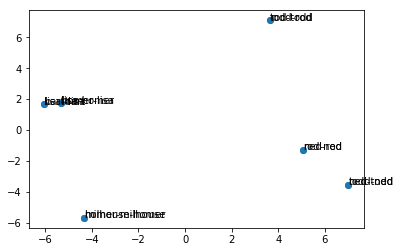

In [163]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n = 6
X = np.vstack(tuples)
pca = PCA(n_components=n)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])
words = list(path_dict.keys())
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Create dendogram to get the number of clusters

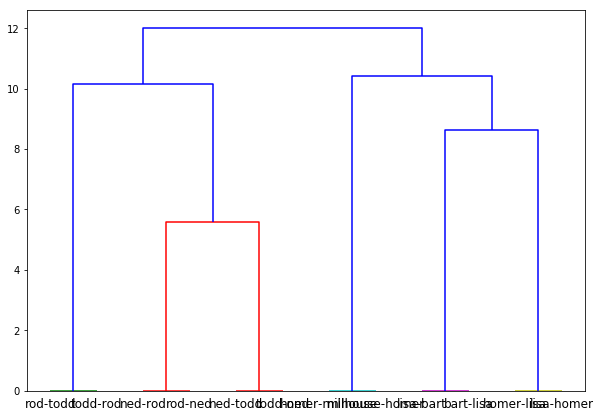

In [164]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

#labelList = range(1, 11)

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            orientation='top',
            labels=words,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

## Clustering

#### Agglomerative (Hierarchical) clustering

In [165]:
from sklearn.cluster import AgglomerativeClustering

#labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
labels = words
agglo_clustering = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=n)
agglo_clustering.fit(X, labels)

agglo_clustering.labels_

array([1, 1, 4, 4, 2, 0, 2, 5, 0, 5, 3, 3], dtype=int64)

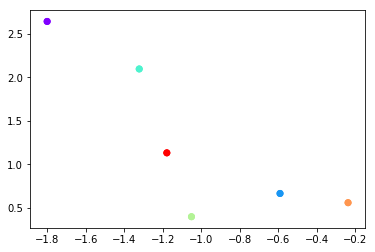

In [166]:
plt.scatter(X[:,0],X[:,1], c=agglo_clustering.labels_, cmap='rainbow')  

In [167]:
agglo_clustering.fit_predict(np.vstack(tuples[0]))

array([0, 4, 1, 1, 3, 2, 0, 4, 5, 2, 0, 5, 3, 0, 0, 0, 0, 4, 1, 4, 2, 2,
       3, 4, 0, 3, 0, 2, 1, 1, 2, 2, 0, 3, 1, 0, 0, 0, 1, 5, 3, 0, 0, 5,
       2, 3, 3, 0, 1, 3, 3, 4, 5, 4, 3, 3, 3, 3, 4, 2, 3, 4, 2, 0, 1, 3,
       4, 2, 0, 0, 1, 5, 3, 2, 0, 4, 3, 1, 5, 5, 0, 0, 5, 5, 3, 1, 4, 4,
       1, 0, 3, 3, 0, 3, 4, 3, 2, 2, 1, 0, 5, 4, 0, 5, 2, 4, 3, 3, 3, 0,
       0, 4, 3, 0, 4, 4, 2, 4, 0, 3, 3, 4, 2, 4, 0, 2, 4, 3, 5, 5, 4, 3,
       5, 4, 5, 0, 3, 2, 4, 3, 0, 0, 4, 2, 0, 1, 3, 0, 3, 4, 4, 0, 0, 5,
       3, 3, 1, 2, 2, 2, 0, 4, 5, 5, 0, 4, 0, 5, 0, 5, 1, 0, 5, 3, 5, 4,
       3, 0, 4, 0, 3, 4, 3, 0, 2, 5, 0, 5, 0, 5, 2, 3, 0, 4, 4, 0, 0, 4,
       1, 3, 3, 3, 2, 5, 0, 2, 0, 1, 3, 3, 2, 3, 4, 4, 1, 2, 0, 0, 4, 5,
       0, 5, 0, 5, 0, 5, 5, 3, 3, 4, 3, 3, 5, 3, 3, 0, 5, 1, 5, 0, 3, 4,
       3, 3, 3, 3, 0, 3, 0, 2, 0, 4, 0, 3, 4, 1, 2, 3, 0, 3, 5, 0, 3, 4,
       5, 4, 4, 4, 5, 1, 3, 2, 2, 0, 4, 0, 3, 3, 0, 2, 4, 2, 5, 3, 4, 1,
       1, 1, 1, 4, 3, 3, 3, 2, 1, 0, 5, 3, 4, 2], d